Discrete Wavelet Transform based Clustering

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyarrow.parquet as pq
import pywt
import time
from sklearn.mixture import GaussianMixture
import datasource_config

In [2]:
# suppress warnings

import warnings
warnings.filterwarnings('ignore')

Import database 

In [3]:
# Set the folder path containing the Parquet files
folder_path = datasource_config.CLUSTERING_SOURCE_DATA_PATH

# Get a list of all Parquet file paths in the folder
file_paths = sorted([os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.parquet')])

# Create an empty list to store the Pandas data frames
dfs = []

# Loop through the file paths, read each Parquet file as a Pandas data frame, and append it to the list
for file_path in file_paths:
    table = pq.read_table(file_path)
    df = table.to_pandas()
    dfs.append(df)

# Concatenate all Pandas data frames into a single data frame
df = pd.concat(dfs, ignore_index=True)

In [4]:
# The whole data frame is stored in `df`

df_pdmp = pd.DataFrame(df["pdmp"].tolist())   # Selecting the `pdmp` column
df_pin = pd.DataFrame(df["pin"].tolist())   # Selecting the `pin` column
df_po = pd.DataFrame(df["po"].tolist())   # Selecting the `po` column

In [5]:
# Assign "fault_class" values to y_true series

fault_true = df["fault_class"]

Define function to perform wavelet transform using discrete wavelet transform

In [6]:
# Define a function to identify wave patterns in a given row
def identify_wave(row):
    
    # Apply discrete wavelet transform (DWT) using the 'db4' wavelet
    coeffs = pywt.dwt(row, 'db4')
    
    # Extract the approximation coefficients (cA) from the DWT result
    cA, _ = coeffs
    
    # Compute the standard deviation of the cA values
    std = np.std(cA)
    
    return std

Applying Wavelet Transform and performing Kmeans Clustering using the coefficients

In [7]:
# Define a list of dataframes
df_list = [df_pdmp, df_pin, df_po]

# Iterate over the dataframes and perform wavelet analysis and clustering
for index, df in enumerate(df_list):

    start_time = time.time()

    # Apply the wave identification function to each row of the dataframe
    wavelets = df.apply(identify_wave, axis=1)

    # Use k-means clustering to cluster the rows based on their wavelet coefficients
    kmeans = KMeans(n_clusters=11, random_state=0).fit(wavelets.values.reshape(-1, 1))

    # Assign a cluster label to each row in a new column in the dataframe
    df['cluster'] = kmeans.labels_

    end_time = time.time()
    processing_time = end_time - start_time
    
    if index == 0:
        print(f"Processing time for pdmp sensor: {processing_time:.3f} seconds")
    elif index == 1:
        print(f"Processing time for pin sensor: {processing_time:.3f} seconds")
    elif index == 2:
        print(f"Processing time for po sensor: {processing_time:.3f} seconds")

Processing time for pdmp sensor: 5.464 seconds
Processing time for pin sensor: 5.398 seconds
Processing time for po sensor: 5.125 seconds


Compare cluster label with actual fault label using a heatmap for each of the sensors

For pdmp sensor

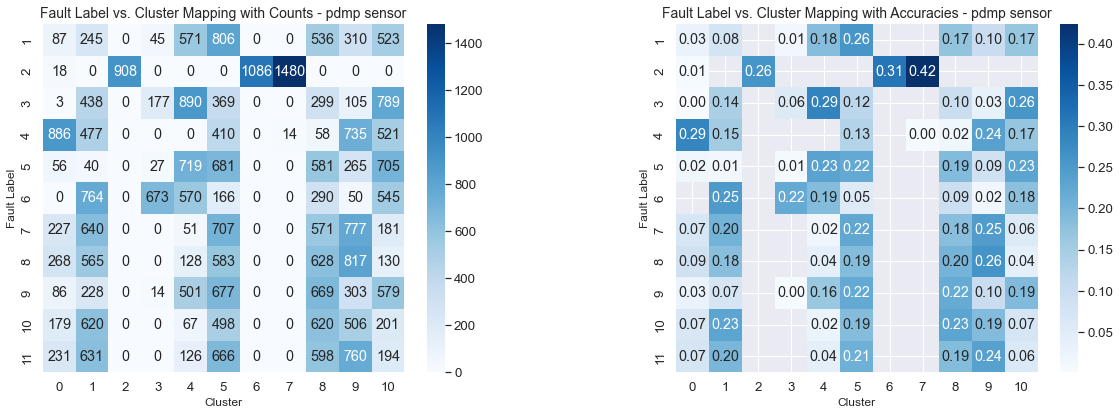

In [11]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pdmp["cluster"])

# calculate the accuracy of each group
grouped = df_pdmp.groupby([fault_true, df_pdmp["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pdmp sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pdmp sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


For pin sensor

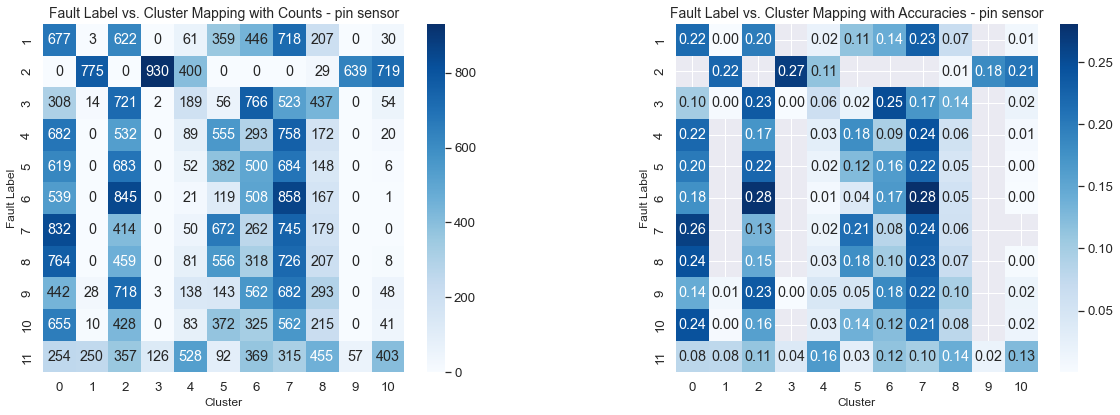

In [9]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pin["cluster"])

# calculate the accuracy of each group
grouped = df_pin.groupby([fault_true, df_pin["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pin sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pin sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


For po sensor

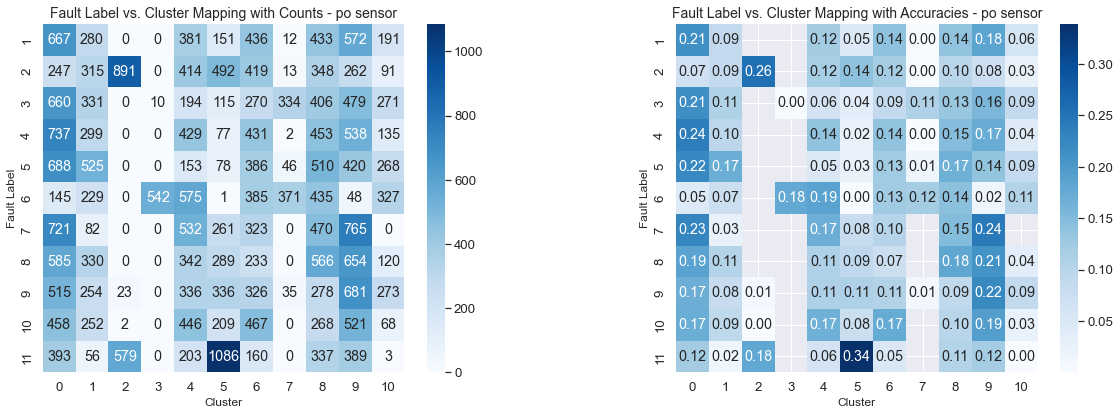

In [10]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_po["cluster"])

# calculate the accuracy of each group
grouped = df_po.groupby([fault_true, df_po["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - po sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - po sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


Applying Wavelet Transform and performing Gaussian Clustering using the coefficients

In [11]:
# Define a list of dataframes
df_list = [df_pdmp, df_pin, df_po]

# Iterate over the dataframes and perform wavelet analysis and clustering
for index, df in enumerate(df_list):

    start_time = time.time()

    # Apply the wave identification function to each row of the dataframe
    wavelets = df.apply(identify_wave, axis=1)

    # Initialize a GaussianMixture object with the desired number of clusters
    gmm = GaussianMixture(n_components=11)
    # Fit the model to the dataset
    gmm.fit(wavelets.values.reshape(-1, 1))
    # Assign the cluster labels to each row of the original dataset
    cluster_labels = gmm.predict(wavelets.values.reshape(-1, 1))
    df['cluster'] = cluster_labels

    end_time = time.time()
    processing_time = end_time - start_time
    if index == 0:
        print(f"Processing time for pdmp sensor: {processing_time:.3f} seconds")
    elif index == 1:
        print(f"Processing time for pin sensor: {processing_time:.3f} seconds")
    elif index == 2:
        print(f"Processing time for po sensor: {processing_time:.3f} seconds")

Processing time for pdmp sensor: 1.644 seconds
Processing time for pin sensor: 1.619 seconds
Processing time for po sensor: 1.596 seconds


Compare cluster label with actual fault label using a heatmap for each of the sensors

For pdmp sensor

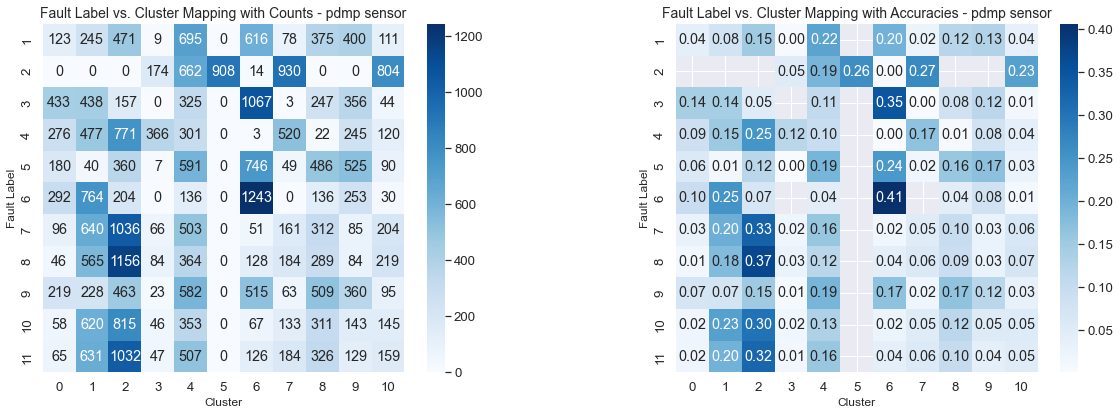

In [12]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pdmp["cluster"])

# calculate the accuracy of each group
grouped = df_pdmp.groupby([fault_true, df_pdmp["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pdmp sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pdmp sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


For pin sensor

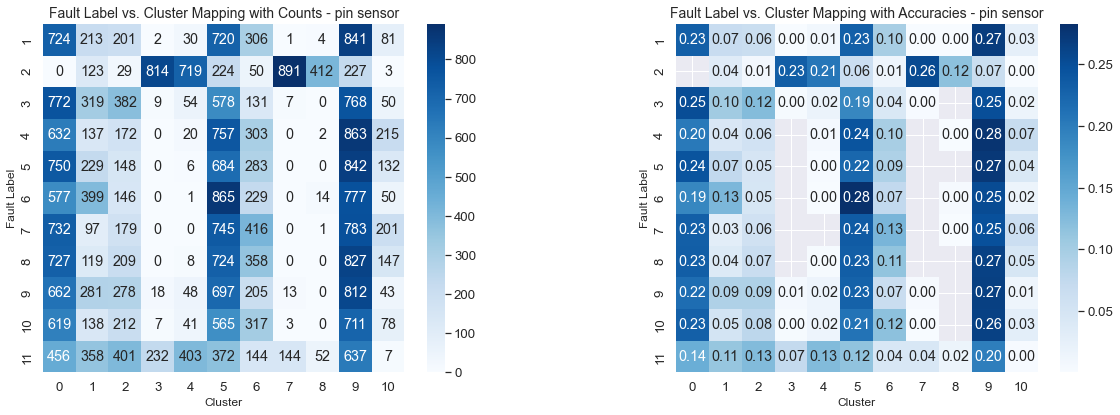

In [13]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_pin["cluster"])

# calculate the accuracy of each group
grouped = df_pin.groupby([fault_true, df_pin["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - pin sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - pin sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


For po sensor

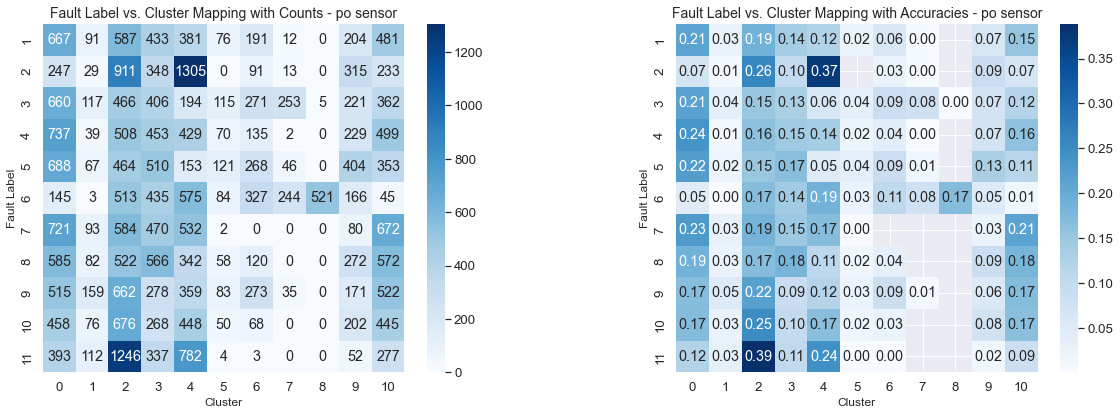

In [14]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_po["cluster"])

# calculate the accuracy of each group
grouped = df_po.groupby([fault_true, df_po["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts - po sensor', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies - po sensor', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()
